# **Advanced Lane Finding** 
***
Utilize more advanced techniques such as gradient and color thresholding and perspective transform to locate the lane lines and detect lane curvature

---

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pickle
import glob
%matplotlib inline

## Calibrate the Camera
### We calibrate the camera first using provided calibration images and plot some examples to demonstrate that the chessboard was correctly found.  

In [2]:
from camera_prep import calibrate, get_dist_mtx
from plot_images import plot_images

In [3]:
images, objpoints, imgpoints = calibrate('camera_cal/ca*.jpg', 9, 6)

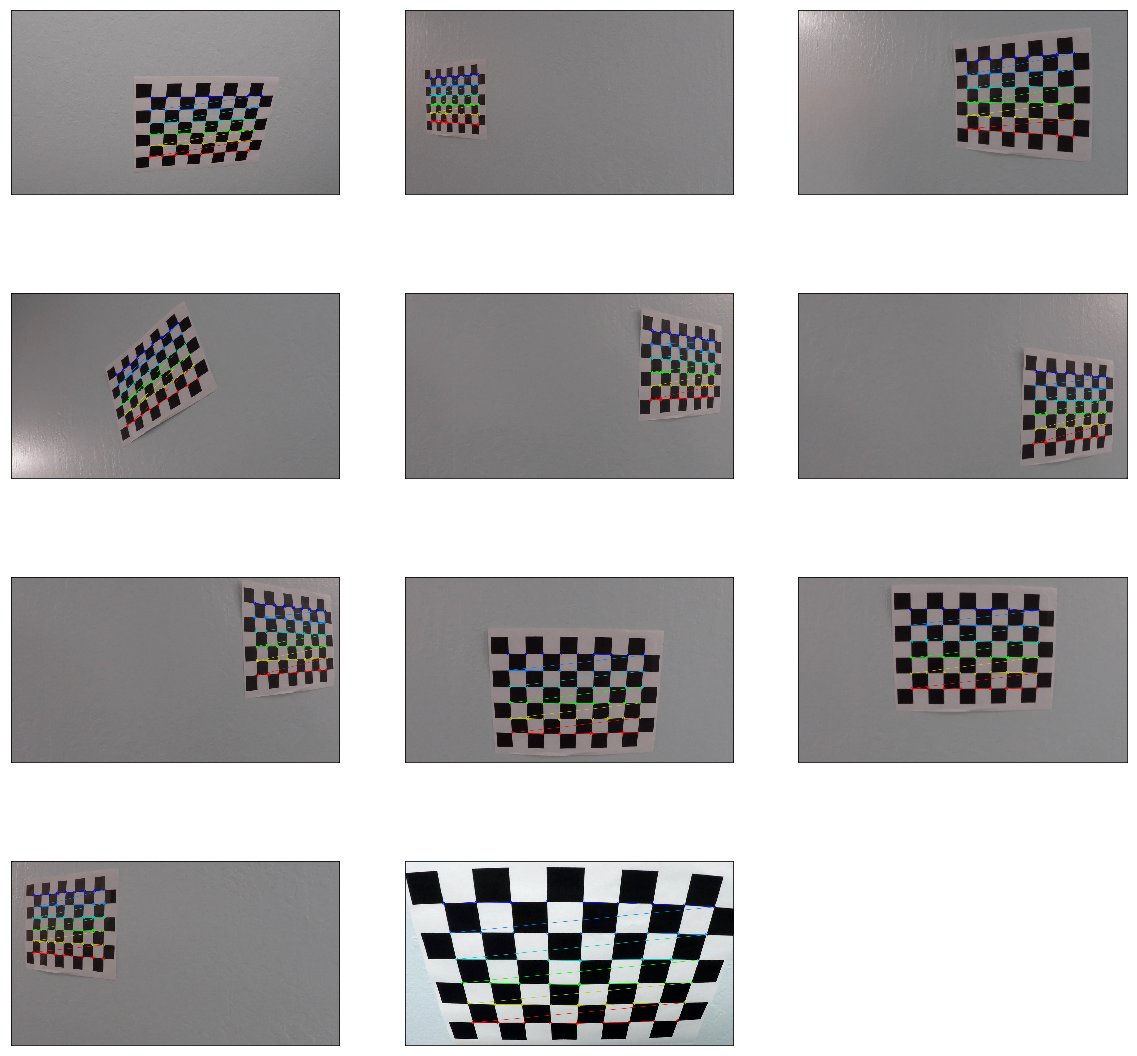

In [4]:
plot_images(images, col=3)

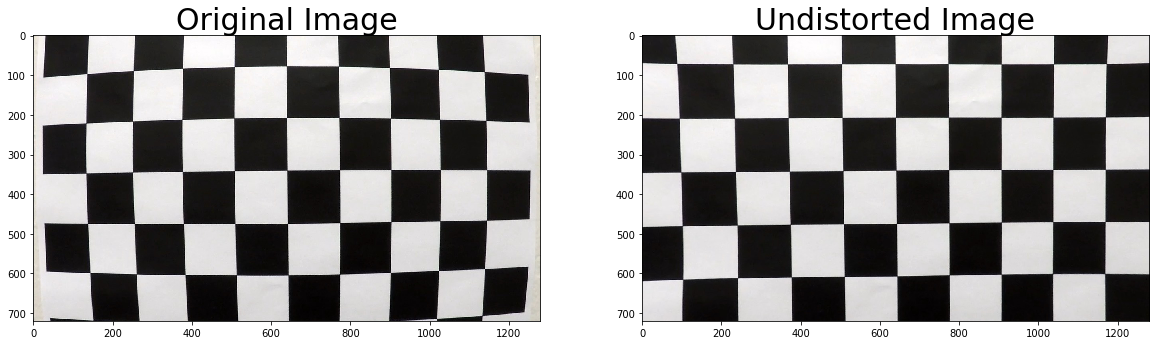

In [5]:
# verify distortion correction appears correct
# Use calibration data to correct distortion
image = mpimg.imread('camera_cal/calibration1.jpg')
undistort, mtx, dist = get_dist_mtx(objpoints, imgpoints, image)

# Undistort an image

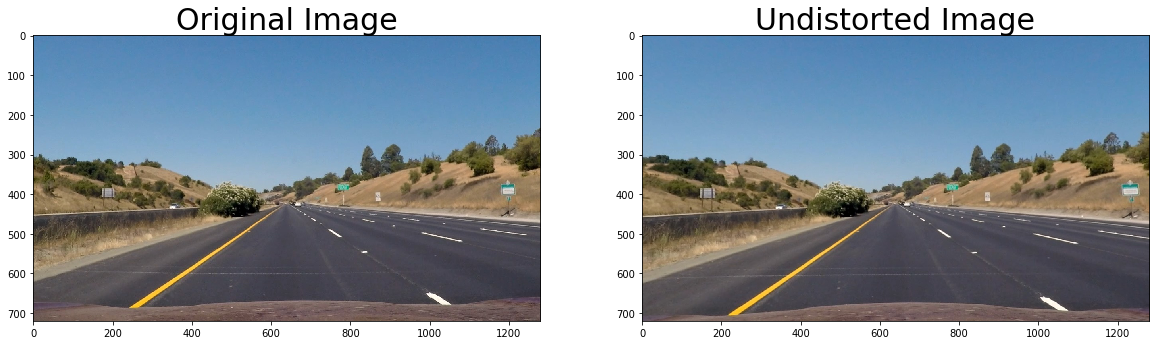

In [6]:
# show a distortion corrected image next to the original
image = mpimg.imread('test_images/straight_lines1.jpg')
undistort = cv2.undistort(image, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistort)
ax2.set_title('Undistorted Image', fontsize=30)

## Use Color Transforms and Gradients to Improve Lane Detection
### Below is some exploration code used to finalize on the transforms and gradients used in the pipeline for image enhancement prior to lane detection.  I decided to use the saturation channel of the HSL colorspace as the primary color channel and for input to gradients because it seemed to separate both yellow and white lane markings out effectively.  The s-channel was thresholded to create a mask which was then OR combined with a gradient mask.  The gradient mask was a combination of thresholded Sobel gradients in the x & y direction and thresholded magnitude and angular direction gradients.  These gradients are implemented in the code in the pipeline itself where the thresholds are defined(as they are below) and in the individual functions which implement the masks and colorspace conversions contained in image_enhance.py

Fig 1: top down image
Fig 2: s-channel binary
Fig 3: binary thresholded gradient of s-channel x-direction
Fig 4: binary thresholded gradient of s-channel y-direction
Fig 5: binary thresholded gradient magnitude of s-channel
Fig 6: binary thresholded gradient angular direction of s-channel
Fig 7: combination mask of the gradients
Fig 8: final mask combination of thresholded s-channel & combined gradients


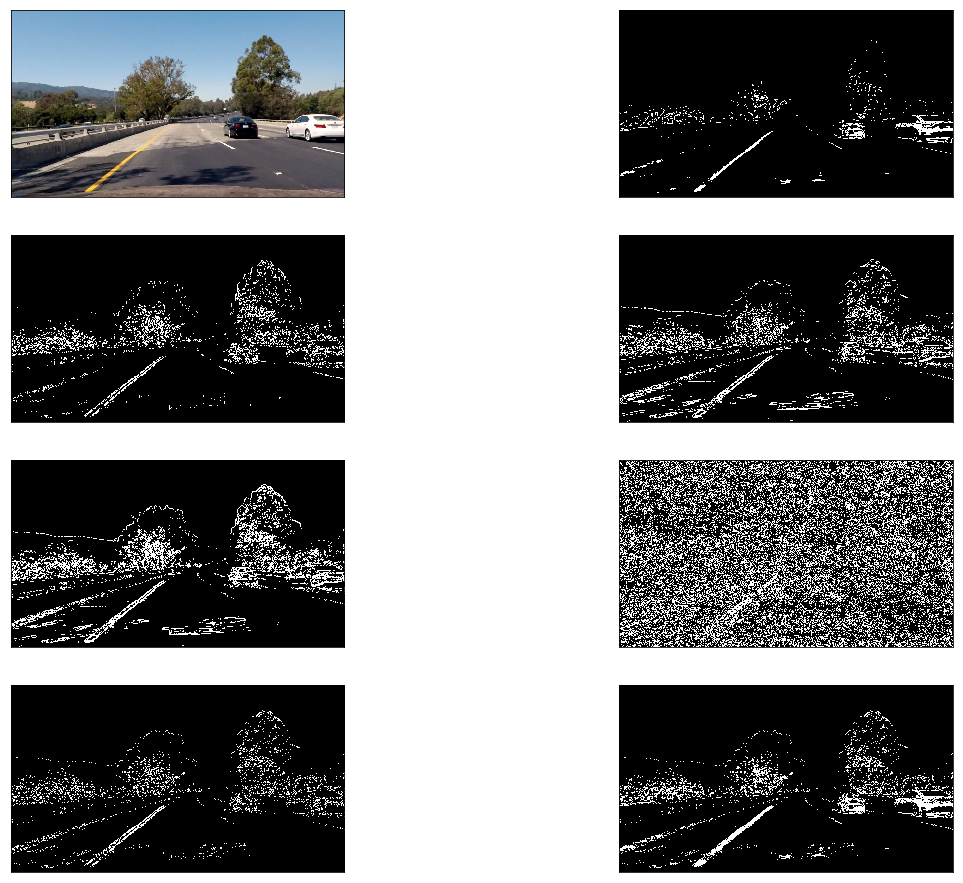

In [7]:
from image_enhance import hls, hls_threshold, mag_thresh, dir_threshold, abs_sobel_thresh
# and explore various thresholds and colorspaces
orig_image = mpimg.imread('test_images/test4.jpg')
images = []
# undistort the image with the calibration data
image = cv2.undistort(orig_image, mtx, dist, None, mtx)
print("Fig 1: top down image")
images.append(image)
hls_all = hls(image)
h_binary = hls_threshold(image, 0, (15, 100))
l_binary = hls_threshold(image, 1, (0.5, 1.))
ksize = 3 # Choose a larger odd number to smooth gradient measurements
# use the s channel as the main image input - prev low 90
s_binary = hls_threshold(image, 2, (150, 255))
# use the s channel of the image as the primary input to gradients
image = hls(image)[:,:,2]
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(20, 100))
# 0.5 1.1
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))
gradient_sx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
gradient_sy = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
combined_gradient = np.zeros_like(mag_binary)
# toss up between & or | the x & y gradients...more noise or'ing but also more signal
combined_gradient[(gradient_sx == 1) & (gradient_sy == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1
# combine the thresholded s-channel and the combined gradients
combined = np.zeros_like(s_binary)
combined[(combined_gradient == 1) | (s_binary == 1)] = 1
print("Fig 2: s-channel binary")
images.append(s_binary)
print("Fig 3: binary thresholded gradient of s-channel x-direction")
images.append(gradient_sx)
print("Fig 4: binary thresholded gradient of s-channel y-direction")
images.append(gradient_sy)
print("Fig 5: binary thresholded gradient magnitude of s-channel")
images.append(mag_binary)
print("Fig 6: binary thresholded gradient angular direction of s-channel")
images.append(dir_binary)
print("Fig 7: combination mask of the gradients")
images.append(combined_gradient)
print("Fig 8: final mask combination of thresholded s-channel & combined gradients")
images.append(combined)
plot_images(images, gray=True)

## Create the Perspective Transform Matrix
### To aid in finding the lanes, we convert the perspective on the image to a top down view.  Since the camera is fixed and hence its perspective does not change, this is a one time operation and is performed by manually measuring source points on one of the straight line test images.  Destination points are created as a rectangle since we know the lane is straight.  The perspective can then be tested on a 2nd straight line image.

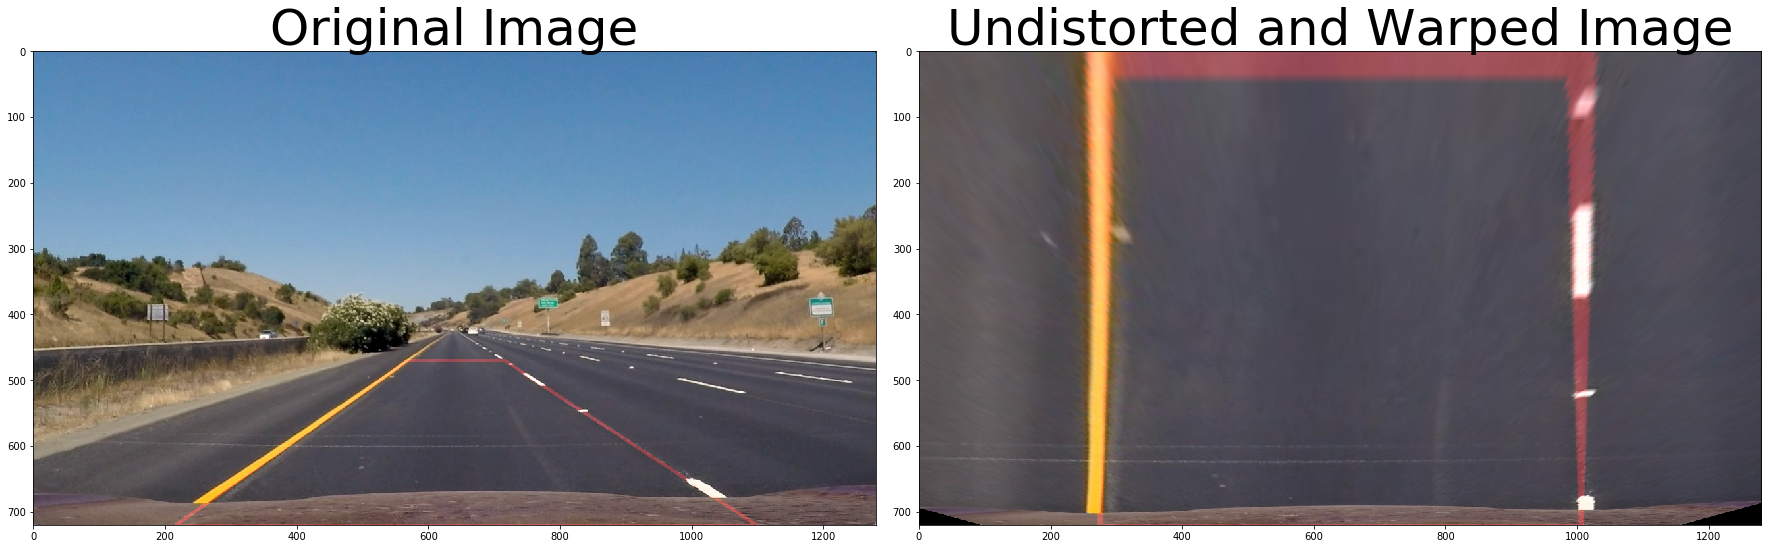

In [8]:
from image_enhance import perspective_xform, set_perspective
# get the perspective xform matrices
orig_image = mpimg.imread('test_images/straight_lines1.jpg')
src, dst, img_size = set_perspective(orig_image)
M_perspective, Minv_perspective = perspective_xform(orig_image, src, dst)
# draw the source points on the original image
# need to add [] to src_pts since it expects a 3D arrary for 3ch image and 
# define color in RGB...note that docs said BGR but it's RGB here
rectangle = np.zeros_like(orig_image).astype(np.uint8)
cv2.polylines(rectangle, [np.array(src, dtype=np.int32)], True, (255, 0, 0), thickness=3)
orig_src = cv2.addWeighted(orig_image, 1, rectangle, 0.3, 0)
# use cv2.warpPerspective() to warp image to a top-down view
top_down = cv2.warpPerspective(orig_src, M_perspective, dsize=img_size, flags=cv2.INTER_LINEAR)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(orig_src)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down, cmap="gray")
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Transform the thresholded image to a top down view
### we utilize the perspective transform matrix on the thresholded image

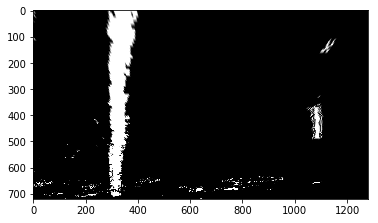

In [9]:
# get a top_down image for lane location
top_down = cv2.warpPerspective(combined, M_perspective, dsize=img_size, flags=cv2.INTER_LINEAR)
plt.imshow(top_down, cmap="gray")

## Locate the lanes
### Using the top down masked image we can now locate the lanes.  locate_lanes() in lanes.py contains the logic and calls the functions outlined below to do this.
1. Find the starting point for the left and right lanes: this is done in find_window_centroids() where I use a convolution across a 50 pixel window to create a  histogram across the bottom half of the top_down binary image to find the peaks which should correspond to the left and right lanes.  The bottom half was chosen as a good tradeoff between collecting enough lane pixels to filter noise and not collecting too much lane data such that lane curvature would affect the starting point.  Once a lane has been detected in a prior frame, the starting x location from that prior frame is utilized rather than a historgram across the entire window.
2. Divide the image into 9 vertical slices and locate the likely lane location for each: I used a search sliding window of 50 pixels around the original x location or x-location of the prior slice.  I also set a tolerance of 30 pixels such that if not enough pixels were found(as is often the case with dashed lines) I simply retain the x-value of the prior slice.  This logic is again located in find_window_centroids()
3. Fit the lane lines: fit_centroids() is used to fit the lane lines and is added to a deque of the 5 most recent fits in Line.coeff.  The Line class from Line.py contains functions to also fit and calculate curvature of the line in real space in meters.  Estimated conversions between pixel space and real space were used for the conversion.  A 2nd order polynomial fit was used to fit both the left and right lanes.

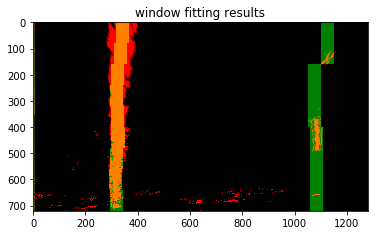

In [10]:
from lanes import locate_lanes
left_lane, right_lane = locate_lanes(top_down)

## Find the curve radius and the distance the vehicle is off center
### Line.set_radius() in Line.py is used to find the radius of curvature which is simply the derivative of the 2nd order polynomial fit for each lane line.  The average of the prior 5 polynomial fit coefficients is utilized for the radius.  The overall curvature is the average of the curvature of the two lanes and is determined in get_avg_radius in lane.py.  A text string for printing this radius in meters is also created and returned by this function.  get_off_center() in lane.py finds the distance the vehicle is off center in meters by converting the number of pixels the center between the right and left lanes is off from the center of the image(the assumed camera location) and converts that to meters, also returning a string for printing.

In [11]:
from lanes import get_avg_radius, get_off_center
# find the curvature

curve_rad, rad_string = get_avg_radius(left_lane, right_lane)
off_ctr, off_ctr_string = get_off_center(left_lane.x_start, right_lane.x_start, top_down.shape[1])
print(rad_string)
print(off_ctr_string)

Curve Radius: 1248 m
0.33 m right of center


## Plot Result Back to Road Identifying Lane
### inverse_perspective() in Lanes.py reverses the perspective transform on the polygon defined by the lane lines and plots that with curve radius and off center strings on the original image. 

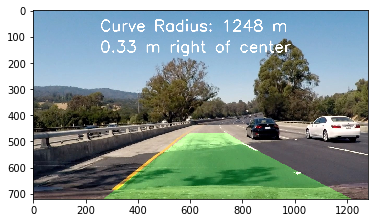

In [17]:
from lanes import inverse_perspective
# project the lane back onto the original image
orig_image = mpimg.imread('test_images/test4.jpg')
result = inverse_perspective(top_down, orig_image, Minv_perspective, left_lane, right_lane, rad_string, off_ctr_string)
plt.imshow(result)

## Run the pipeline on all the test images

In [13]:
import os
files = os.listdir("test_images/")
print(files)

['.DS_Store', 'straight_lines1.jpg', 'straight_lines2.jpg', 'test1.jpg', 'test2.jpg', 'test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg']


processing:  test_images/straight_lines1.jpg
writing:  test_image_output/out_straight_lines1.jpg
processing:  test_images/straight_lines2.jpg
writing:  test_image_output/out_straight_lines2.jpg
processing:  test_images/test1.jpg
writing:  test_image_output/out_test1.jpg
processing:  test_images/test2.jpg
writing:  test_image_output/out_test2.jpg
processing:  test_images/test3.jpg
writing:  test_image_output/out_test3.jpg
processing:  test_images/test4.jpg
writing:  test_image_output/out_test4.jpg
processing:  test_images/test5.jpg
writing:  test_image_output/out_test5.jpg
processing:  test_images/test6.jpg
writing:  test_image_output/out_test6.jpg


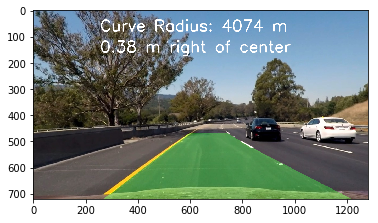

In [14]:
from pipeline import pipeline
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
# NOTE: I used a separate directory for output and also added an image
#       from the challenge video which my pipeline doesn't work with
#       Decided to tackle the challenge later so the pipeline still
#       isn't working on that section of video: challenge.jpg
for file in files:
    filename, filext = os.path.splitext(file)
    if filext.lower().endswith(('.jpg', '.jpeg', '.png')):
        
        image_in = 'test_images/' + file
        print("processing: ", image_in)
        image = mpimg.imread(image_in)
        result, left_lane, right_lane = pipeline(image, mtx, dist, M_perspective, Minv_perspective)
        plt.imshow(result)
        image_out = 'test_image_output/out_' + file
        print("writing: ", image_out)
        mpimg.imsave(image_out, result)

## Utilize the pipeline on the project video
### Here I utilize a LaneTracker object defined in LaneTracker.py to track the important parameter input(distortion matrix and perspective and inverse perspective matrices) and the frame to frame parameters like the lanes and their current parameters.

In [15]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [16]:
from LaneTracker import LaneTracker
white_output = 'project_output_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
lane_track = LaneTracker(mtx, dist, M_perspective, Minv_perspective)
white_clip = clip1.fl_image(lane_track.process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_output_video.mp4
[MoviePy] Writing video project_output_video.mp4


100%|█████████▉| 1260/1261 [06:41<00:00,  2.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output_video.mp4 

CPU times: user 6min 25s, sys: 1min 23s, total: 7min 48s
Wall time: 6min 43s
